<a href="https://colab.research.google.com/github/1kaiser/Snow-cover-area-estimation/blob/main/ECOSTRESS_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/1kaiser/Snow-cover-area-estimation/releases/download/v1/ECOSTRESS.zip
!unzip -o /content/ECOSTRESS.zip -d /content/files 

In [52]:
image_dir = r'/content/files'

#############################################################################
prefix = "ECO2LSTE.001_SDS_"
bandend = ["LST", "PWV", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = prefix+bandend[0]

expression_b2 = prefix+bandend[1]



temp_dir = r'/content/'
import os

imgs_list_b1 = [f for f in os.listdir(image_dir) if f.__contains__(expression_b1)]

imgs_list_b1.sort(reverse=True) 

                    #<<<< to start file streaming from the last date 2022 >> 2021 >> 2020 ....

imgs_path_b1 = [os.path.join(image_dir, i) for i in imgs_list_b1 if i != 'outputs']
print(len(imgs_path_b1))

354


In [ ]:
imgs_path_b1

In [ ]:
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/DEM.tif 
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/SLOPE.tif
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/ASPECT.tif

In [ ]:
!pip install rasterio

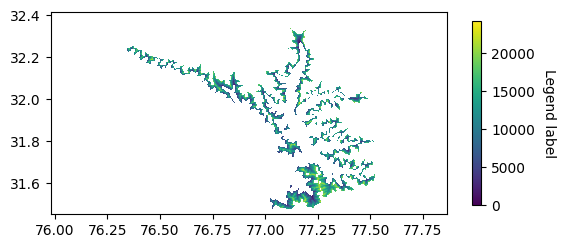

Minimum: 6738
Maximum: 24325
Mean: 14066.0086914008
Standard Deviation: 424.03853597574795


In [42]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the DEM raster file
dem_in = rasterio.open('/content/DEM.tif')
dem_data = dem_in.read(1, masked=True)

# Set the range values to select
min_range = 2000
max_range = 3000

# Apply the range condition to the DEM data
dem_data_range = np.where((dem_data >= min_range) & (dem_data <= max_range), dem_data, np.nan)

# Open the raster file
src = rasterio.open(imgs_path_b1[4])
data = src.read(1, masked=True)

left, bottom, right, top = src.bounds

# Calculate the statistics of the data
min_val = np.min(data)
max_val = np.max(data)
mean_val = np.mean(data)
std_val = np.std(data)

# Create a plot
fig, ax = plt.subplots()

# Show the raster on the plot
ax.imshow(dem_data_range, extent=[left, right, bottom, top])
# im = ax.imshow(data, extent=[left, right, bottom, top])

# Add a legend
cbar = plt.colorbar(im, ax=ax, shrink=0.5)

# Set the label for the legend
cbar.ax.set_ylabel('Legend label', rotation=270, labelpad=15)

# Show the plot
plt.show()

# Print the statistics
print("Minimum:", min_val)
print("Maximum:", max_val)
print("Mean:", mean_val)
print("Standard Deviation:", std_val)


Raster transformation and reshaping completed.


In [79]:
from osgeo import gdal, osr

def transform_and_reshape_raster(raster_file, dem_file, output_file):
    # Open the DEM file
    dem_dataset = gdal.Open(dem_file, gdal.GA_ReadOnly)
    if dem_dataset is None:
        print("Failed to open the DEM file.")
        return

    # Get the DEM projection and geotransform information
    dem_projection = dem_dataset.GetProjection()
    dem_geotransform = dem_dataset.GetGeoTransform()

    # Open the raster file
    raster_dataset = gdal.Open(raster_file, gdal.GA_ReadOnly)
    if raster_dataset is None:
        print("Failed to open the raster file.")
        return

    # Get the raster projection and geotransform information
    raster_projection = raster_dataset.GetProjection()
    raster_geotransform = raster_dataset.GetGeoTransform()

    # Create a new dataset for the output file
    driver = gdal.GetDriverByName('GTiff')
    output_dataset = driver.Create(output_file, dem_dataset.RasterXSize, dem_dataset.RasterYSize, 1, gdal.GDT_Float32)

    # Set the output dataset's projection and geotransform
    output_dataset.SetProjection(dem_projection)
    output_dataset.SetGeoTransform(dem_geotransform)

    # Reproject and reshape the raster
    gdal.ReprojectImage(raster_dataset, output_dataset, raster_projection, dem_projection, gdal.GRA_NearestNeighbour)

    # Close the datasets
    dem_dataset = None
    raster_dataset = None
    output_dataset = None

    print("Raster transformation and reshaping completed.")





import rasterio
import matplotlib.pyplot as plt

def plot_dem_raster(file_path):
    # Open the DEM raster file
    dem_in = rasterio.open(file_path)
    dem_data = dem_in.read(1, masked=True) * 0.02 - 273.15
    left, bottom, right, top = dem_in.bounds
    fig, ax = plt.subplots()

    # Show the raster on the plot
    im = ax.imshow(dem_data , extent=[left, right, bottom, top])

    # Add a legend
    cbar = plt.colorbar(im, ax=ax, shrink=0.5)

    # Set the label for the legend
    cbar.ax.set_ylabel('Legend label', rotation=270, labelpad=15)

    # Show the plot
    plt.show()

import rasterio
import numpy as np
import numpy.ma as ma

def calculate_raster_statistics(file_path):
    # Open the raster file
    src = rasterio.open(file_path)
    data = src.read(1, masked=True) * 0.02 - 273.15

    # Calculate the statistics of the data
    min_val = np.min(data)
    max_val = np.max(data)
    mean_val = np.mean(data)
    median_val = ma.median(data)  # Use numpy.ma.median() for masked arrays
    std_val = np.std(data)

    # Calculate the number of pixels
    num_pixels = np.sum(~data.mask)

    # Get the pixel size
    x_resolution = src.res[0]
    y_resolution = src.res[1]

    return min_val, max_val, mean_val, median_val, std_val, num_pixels, x_resolution, y_resolution



pathb1 = imgs_list_b1[10]
pathb2 = pathb1.replace(expression_b1, expression_b2)
temp_dir = f'/content/'

raster_file = imgs_path_b1[4]

transform_and_reshape_raster(raster_file, str(temp_dir)+'DEM.tif', str(temp_dir)+'output_reprojected.tif')

E_difference = 500
last_num = int(7000/E_difference)
for i in range(1, last_num + 1):
  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    -A {temp_dir}DEM.tif \
    --A_band 1 \
    -B {temp_dir}output_reprojected.tif \
    --B_band 1 \
    --outfile=SmallerFileB"{str(i)}".tif \
    --NoDataValue=0 \
    --calc="((A.astype(float)>{E_difference*(i-1)})*(A.astype(float)<={E_difference*i})*1)*(B.astype(float))"
  print()
  # plot_dem_raster('SmallerFileB'+str(i)+'.tif')
  # calculate_raster_statistics('SmallerFileB'+str(i)+'.tif')
        

# !gdal_calc.py \
#   --overwrite \
#   --type=Float32 \
#   -A {pathb1} \
#   --A_band 1 \
#   -B {pathb2} \
#   --B_band 1 \
#   --outfile={temp_dir}"NDSI_result.tif" \
#   --calc="(A.astype(float) - B)/(A.astype(float) + B)"

Raster transformation and reshaping completed.
0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 14.. 

In [80]:
imgs_path_b1[4]

'/content/files/ECO2LSTE.001_SDS_LST_doy2022239211328_aid0001.tif'

In [97]:
def extract_doy_year(filename):
    year_start_index = filename.find('doy') + 3
    year_end_index = year_start_index + 4
    doy_start_index = year_end_index
    doy_end_index = doy_start_index + 3

    year = int(filename[year_start_index:year_end_index])
    doy = int(filename[doy_start_index:doy_end_index])

    return doy, year


filename = "/content/files/ECO2LSTE.001_SDS_LST_doy2022089211328_aid0001.tif"
doy, year = extract_doy_year(filename)
print("Day of Year:", doy)
print("Year:", year)

Day of Year: 89
Year: 2022


Day of Year: 202
Year: 1132


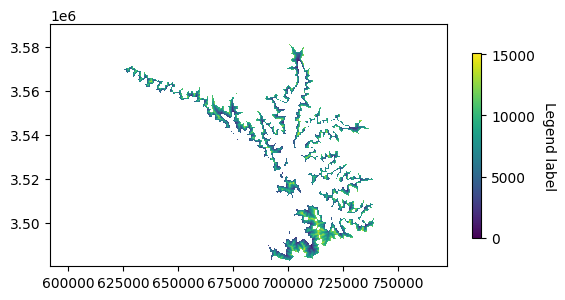

Minimum: --
Maximum: --
Mean: --
Standard Deviation: --


In [56]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the DEM raster file
dem_in = rasterio.open('/content/DEM.tif')
dem_data = dem_in.read(1, masked=True)

# Set the range values to select
min_range = 2000
max_range = 3000

# Apply the range condition to the DEM data
dem_data_range = np.where((dem_data >= min_range) & (dem_data <= max_range), dem_data, np.nan)

# Open the raster file
src = rasterio.open('/content/SmallerFileB6.tif')
data = src.read(1, masked=True)

left, bottom, right, top = src.bounds

# Calculate the statistics of the data
min_val = np.min(data)
max_val = np.max(data)
mean_val = np.mean(data)
std_val = np.std(data)

# Create a plot
fig, ax = plt.subplots()

# Show the raster on the plot
ax.imshow(dem_data_range, extent=[left, right, bottom, top])
# im = ax.imshow(data, extent=[left, right, bottom, top])

# Add a legend
cbar = plt.colorbar(im, ax=ax, shrink=0.5)

# Set the label for the legend
cbar.ax.set_ylabel('Legend label', rotation=270, labelpad=15)

# Show the plot
plt.show()

# Print the statistics
print("Minimum:", min_val)
print("Maximum:", max_val)
print("Mean:", mean_val)
print("Standard Deviation:", std_val)


In [76]:
import rasterio
import numpy as np
import numpy.ma as ma

def calculate_raster_statistics(file_path):
    # Open the raster file
    src = rasterio.open(file_path)
    data = src.read(1, masked=True) * 0.02 - 273.15

    # Calculate the statistics of the data
    min_val = np.min(data)
    max_val = np.max(data)
    mean_val = np.mean(data)
    median_val = ma.median(data)  # Use numpy.ma.median() for masked arrays
    std_val = np.std(data)

    # Calculate the number of pixels
    num_pixels = np.sum(~data.mask)

    # Get the pixel size
    x_resolution = src.res[0]
    y_resolution = src.res[1]

    return min_val, max_val, mean_val, median_val, std_val, num_pixels, x_resolution, y_resolution


In [77]:
calculate_raster_statistics('/content/SmallerFileB3.tif')

(-138.39,
 22.529999,
 10.413447398608055,
 10.549988,
 7.788773261482077,
 1725211,
 29.012124550353303,
 29.012124550353295)

In [78]:
calculate_raster_statistics('/content/SmallerFileB6.tif')

(-22.710007,
 14.869995,
 9.012767166857738,
 9.3699951171875,
 2.3514199916921537,
 1252588,
 29.012124550353303,
 29.012124550353295)